# Error analysis
Let's see where the text-only model and the reader-aware models differed, and where some outperformed others.

In [1]:
import gzip
text_only_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/text_only_model/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
reader_token_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
reader_attn_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/author_attention_data/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
reader_text_embed_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/author_text_embed_data/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
reader_subreddit_embed_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/author_subreddit_embed_data/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
print(len(text_only_output))
print(len(reader_token_output))
print(len(reader_attn_output))
print(len(reader_text_embed_output))
print(len(reader_subreddit_embed_output))

56097
56097
56097
56097
56097


In [2]:
import torch
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt')
print(len(test_data))

56097


In [3]:
## combine everything lol
import pandas as pd
combined_data = pd.DataFrame([
    text_only_output,
    reader_token_output,
    reader_attn_output,
    reader_text_embed_output,
    reader_subreddit_embed_output,
    test_data['source_text'],
    test_data['target_text'],
    test_data['reader_token_str'],
    test_data['author_has_subreddit_embed'],
    test_data['author_has_text_embed'],
    test_data['article_id'],
], index=['text_only_output', 'reader_token_output', 'reader_attn_output', 'reader_text_embed_output', 'reader_subreddit_embed_output', 'source_text', 'target_text', 'reader_token', 'author_has_subreddit_embed', 'author_has_text_embed', 'article_id']).transpose()
print(combined_data.shape)
display(combined_data.head())

(56097, 11)


,text_only_output,reader_token_output,reader_attn_output,reader_text_embed_output,reader_subreddit_embed_output,source_text,target_text,reader_token,author_has_subreddit_embed,author_has_text_embed,article_id
0,Do you have contact info for her?,Do you have contact info for her?,How old are you?,Do you have any idea of what you'd like to do ...,Do you have any other family or friends who ca...,"So I have this friend, we haven't been friends...",It is entirely possible that she actually is h...,UNK,False,False,dizaob
1,Did you have liability insurance on your vehicle?,Did you have liability insurance on your vehicle?,Do you have significant medical bills?,Do you have an emergency fund of 3 to 6 to 6 m...,Do you have an employment contract?,My wife rear ended a guy on the freeway during...,Counter sue him for what?,UNK,False,False,9mk88t
2,So you'd have to go back to the bank every mon...,So you'd have to go back to the bank every mon...,Are you sure you can actually deposit the mone...,What do you do in your free time?,What's the interest rate on the car loan?,My paypal is linked to my bank. If I buy some...,Do you have a job?,UNK,True,True,8dk9mm
3,Why do you feel the need to hide this?,Why do you feel the need to hide this?,What the hell is wrong with you?,What are you doing with your time when you gra...,What is wrong with you?,My daughter recently got her first period. She...,Have there been any consequences for son for t...,UNK,False,False,dxi91m
4,How is she holding your car hostage?,How is she holding your car hostage?,What kind of parent asks their child to pay?,Do you have any friends that might be able to ...,How do you know they didn’t give you a check?,"Before you judge me on the title, please hear ...",Or are you saying your savings IS your income?,UNK,False,False,dpfgze


In [4]:
## add subreddit data
post_data = pd.read_csv('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz', sep='\t', compression='gzip', index_col=False, usecols=['id', 'subreddit'])
post_data.rename(columns={'id' : 'article_id'}, inplace=True)
if('subreddit' not in combined_data.columns):
    combined_data = pd.merge(combined_data, post_data, on='article_id', how='left')

Compute BLEU-1 scores for all pairs of questions and test data.

In [5]:
from tqdm import tqdm
tqdm.pandas()
from model_helpers import compute_text_bleu
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
bleu_weights = [1.0, 0., 0., 0.]
model_output_cols = list(filter(lambda x: x.endswith('_output'), combined_data.columns))
combined_data = combined_data.assign(**{
    'target_text_tokens' : combined_data.loc[:, 'target_text'].apply(lambda x: tokenizer.tokenize(x.lower()))
})
for model_output_col in model_output_cols:
    combined_data = combined_data.assign(**{
        f'{model_output_col}_tokens' : combined_data.loc[:, model_output_col].apply(lambda x: tokenizer.tokenize(x.lower()))
    })
    combined_data = combined_data.assign(**{
        f'{model_output_col}_BLEU' : combined_data.progress_apply(lambda x: compute_text_bleu(x.loc[f'{model_output_col}_tokens'], x.loc['target_text_tokens'], weights=bleu_weights), axis=1)
    })

  0%|          | 0/56097 [00:00<?, ?it/s]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overl

In [6]:
pd.set_option('display.max_colwidth', 1000)
model_text_1 = 'text_only_output'
model_text_2 = 'reader_token_output'
top_k = 10
for subreddit_i, data_i in combined_data.groupby('subreddit'):
    print(f'{model_text_1} vs. {model_text_2}: subreddit={subreddit_i}')
    data_i = data_i.assign(**{
        'BLEU_diff' : data_i.loc[:, f'{model_text_2}_BLEU'] - data_i.loc[:, f'{model_text_1}_BLEU']
    })
    data_i.sort_values('BLEU_diff', inplace=True, ascending=False)
    print(f'{model_text_2} > {model_text_1}')
    display(data_i.loc[:, ['source_text', 'target_text', model_text_1, f'{model_text_1}_BLEU', model_text_2, f'{model_text_2}_BLEU', 'reader_token']].head(20))
    print(f'{model_text_1} > {model_text_2}')
    data_i.sort_values('BLEU_diff', inplace=True, ascending=True)
    display(data_i.loc[:, ['source_text', 'target_text', model_text_1, f'{model_text_1}_BLEU', model_text_2, f'{model_text_2}_BLEU', 'reader_token']].head(20))

text_only_output vs. reader_token_output: subreddit=Advice
reader_token_output > text_only_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
41092,"I just started my freshman year of high school and starting last year in middle school I've been obsessed with getting a girlfriend. I don't know why I care so much, because I basically just imagine myself doing stuff with girls, which I would normally do with friends (with the odd but of handholding). I hate to seem emo because I think I'm a pretty cheerful happy guy in general, but it's gotten to the point where if I see a freshman couple in the hallway or see pictures of other freshman in relationships I get sad. I feel really anxious about the that I don't have a girlfriend, because I'm very average in looks and whatnot and I perform well academically, and Im not bothered by who it is as long as I can have the authentic boyfriend-girlfriend relationship, so I don't see any distinct disadvantages that I have. I've now asked out 15 girls I've known over the course of 8th and 9th grade. What can I do to further increase my chances of getting a girlfriend or stop being bothered by...",what are your goals?,You're not allowed to have a girlfriend either?,0.060239,What are your interests?,0.800000,<RESPONSE_TIME_0_AUTHOR>
22228,"I work in an adult store. The job itself is amazing, but everyday I get at least one prank call. I just want some really witty comebacks as people usually call with a group of friends. I feel like embarrassing them is the best course of action to make them realise they’re being immature and stupid. Keep in mind most of these callers are in their teens, and think sex is funny.",Are you a girl?,Have you ever asked them to hang out with you?,0.120478,Are you a prude?,0.800000,<RESPONSE_TIME_0_AUTHOR>
23194,"Hello all, im a 14 year old girl and im currently in high school. I made this account as a way to vent my feelings. If this post is not appropriate, feel free to remove but please direct me to a subreddit where i can talk about it. Since you guys are teenagers too i suppose, i can talk to you about this i guess. My parents are all good but sometimes they have very physical fights. They both hit each other and most of the time it is too violent for me to control. Things usually calm down after a day or two. I also have a younger sister (she's 5) and i usually go out of the house with her whenever the fights happen. Also my parents are kind of conservative in nature, i dont know how they would feel if i told them that i liked girls too. Ive never dated anyone but ive had a fair amount of crushes. At my school, if it were to get out that i was bi, then id be shunned and shamed about how it isnt right. I dont really have friends and the ones that i have are mostly extremely toxic in na...",Do you have any family members you can talk to or even stay with?,Are you planning on going to college?,0.200000,Do you have a friend or family member you can talk to about this?,0.666667,<EXPERT_PCT_0_AUTHOR>
26913,"tldr at the bottomRapid Fire Background Info. She \[27F\] is a teacher (California). I \[27M\] work in the tech field. Been dating for 6.5 years. Both up to our ears in student loan debt. I am likely to start a new job soon which would relocate us. I just want her to be happy.So, as most of my American reddit counterparts will know, the life of a teacher here is not always the best scenario, and its the reason that I want to bring this subject up with her. Before I start, please understand that this is not motivated by money. It is a small part, but honestly I make enough in my profession to ensure food is kept on the table, and our debts get paid. What irks me about her job is the work life balance. Absolutely. Abysmal. Many teachers here will know just how grueling it can be. 10 hours in the classroom with a bunch of kids (she teaches elementary). That's not enough. You're expected to do lesson planning at home. Need supplies? Yeah, that's on you. Parent's think their kid is spec...

text_only_output > reader_token_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
53220,"I have been depressed for a while now, and finally got up the courage to tell my parents about it, and at first they just said the typical, ""Life gets better"", which doesn't help me with my depression, nor does it make it worse. Anyways, a couple of days later, when I was still being open with them about my depression, my Dad came into my room and said that I just need to ""cut it out"" and that my life wasn't bad at all (although it is in many ways, that I had opened up to him about), as well as that I'm being a baby and many people struggle with much more and he sounded genuinely mad. After this experience, I started to fake smile every day once again, and I believe (not 100% sure), this made my parents think that this method worked, so they started doing it on a more consistent basis, how do I be honest with them, without hurting them, and tell them that they have been making it worse.",How old are you?,How old are you?,1.000000,"For example, did you tell them you’re depressed or did they find it difficult to believe?",0.019915,<EXPERT_PCT_1_AUTHOR>
53221,"I have been depressed for a while now, and finally got up the courage to tell my parents about it, and at first they just said the typical, ""Life gets better"", which doesn't help me with my depression, nor does it make it worse. Anyways, a couple of days later, when I was still being open with them about my depression, my Dad came into my room and said that I just need to ""cut it out"" and that my life wasn't bad at all (although it is in many ways, that I had opened up to him about), as well as that I'm being a baby and many people struggle with much more and he sounded genuinely mad. After this experience, I started to fake smile every day once again, and I believe (not 100% sure), this made my parents think that this method worked, so they started doing it on a more consistent basis, how do I be honest with them, without hurting them, and tell them that they have been making it worse.",How old are you?,How old are you?,1.000000,"For example, if you were in a situation where you were abused, what would they do?",0.024324,<RESPONSE_TIME_0_AUTHOR>
30552,"I don't want to help myself, and in return I'm failing everyone around me. I'm married. My wife is so talented and focused, but I am the opposite. Every job I touch, I do very well and climb above most people around me - then I quit. I find some reason to get offended, dissatisfied, or bored of my situation. I'm always coming up with big visions and grandure of the future, only to feel like I'm not capable of reaching my goals. I feel defeated and shameful and so I get stuck mentally. I have severe depression and anxiety and it feels like no one around me can help. I've been to counselors, pastors, teachers, friends, etc. and I still feel stuck. I was once a Christian, but I lived years trying to please other people and live for what they wanted and not what I needed for myself. I spent years trying to please a God, only to earn his respect. I never felt love from God above or my own blood father. I feel stuck. Stuck trying to live life to please people. All I want is everyone's ap...",What are your goals?,What are your goals?,1.000000,Have you tried writing a note to your wife about this?,0.098639,<RESPONSE_TIME_0_AUTHOR>
30211,"Okay this might just sound like a rant I’m sorry... I am always just down all the time and I’m just to tired to do anything. I have lost interest over things I have worked on for years and hobbies I would usually really enjoy. I have became more isolated and like to be alone (by choice) I can’t stand being alone if I don’t want to be I always am just too hard on myself for the most stupid reasons and have struggles with self confidence. I honestly think I’m the most ugliest person I’ve met. I hate my legs my hairline my nose my hair my eyes. Basically anything, u n

text_only_output vs. reader_token_output: subreddit=AmItheAsshole
reader_token_output > text_only_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
21816,"Lots and lots of ugly background here but I'll try not to wander. My wife I have been separated for 2 years, ink to paper on an ugly and contentious divorce in May. I have primary custody of our two kids (daughter 17 and son 14) and live in the home which we've owned for 20 years. On Monday I came home to find my son and two of his friends up on the roof to our little sun deck. I asked him what he was doing and if he was being safe. They said they were playing army and since I've coached the other two kids in mountain biking for almost 6 years now, I knew their parents wouldn't mind either. So I told him to put the ladder away when he was done and to keep his phone on in case I needed him to come down. I was actually most perturbed because he didn't put the ladder away. So they did this every day this week until Thursday when my daughter came home from her CIT job and in her every so sweet and acerbic tone asked me if I was really so stupid to think my son and friends were playing ...",YTA what is wrong with you?,Are you sure you want to have a relationship with your kid and not with your neighbor?,0.089035,What the heck is wrong with you?,0.743038,<EXPERT_PCT_0_AUTHOR>
27763,"My husband is sterile due to a hormonal condition and so we have been trying to find a sperm donor for over two years now. The problem is that my husband and I both come from Jewish families and my husband insists any potential sperm donor is Jewish. We don’t live in a western country so finding Jewish sperm donors is impossible. We flew to America to get IVF done at a clinic but unfortunately the pregnancy didn’t go to term. It’s too expensive to try again right now.I was recently messaged by a potential donor. He ticked all the right boxes. Successful, handsome, fit, healthy, etc. Honestly the best donor by far we have met. I knew my husband would say no since he wasn’t Jewish... so I lied. I asked the donor to pretend. He was hesitant but after I explained the long ordeal he went a head with it. I just confirmed I’m pregnant.AITA?",Are you prepared to do that?,"You’re trying to find a way to have a sperm donor, what the hell are you trying to do?",0.072644,What are you supposed to do?,0.714286,<EXPERT_PCT_0_AUTHOR>
42739,"I am the by-product of my parents extra-marital affair. Both of them had spouses at the time. My birth-mother got pregnant and had to tell her husband as he was overseas when I was conceived so there was no way I was his. A few months after I was born they decided not to divorce. I was given to my grandparents on my mothers side to raise with my birth father secretly paying child support without his wife's knowledge.Both my parents had other children, my dad's side knows nothing about me but my siblings on my mum's side were told that I am adopted by my grandparents. Recently I decided that I wanted to know more about my dad's family and I sent a friend's request to one of my siblings and my dad so I could get to know him. Well he freaked out and contacted my birth mum and they asked to speak to me over Skype. They both told me that they couldnt risk staying in contact with me and told me that they were going no-contact and to please respect it and move on with my life. Well I did...",INFO: how did you find out all this information?,Wouldn't that be awesome?,0.090909,"Also, how did you find out about this information?",0.727273,<RESPONSE_TIME_1_AUTHOR>
27195,"Hi reddit! So first off a bit of background, I currently have a fractured elbow which I managed to do five days ago. As you can imagine, that makes it pretty difficult to do anything, never mind cleaning. I (19f) live with my boyfriend (23m) in a cosy little 2 bed flat with our kitten. It’s been a long standing argument between my boyfriend and I about cleaning. In our current jobs, I work more hours in longer shifts than him and work evenings and week

text_only_output > reader_token_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
28893,"So , my boyfriend is very gaseous and farts *a lot*. At first it was kinda funny, and my roommate and her boyfriend found it a bit amusing, so it was a bit acceptable. But he sleeps over a lot and would find no problem farting in the room, in bed with me, among company, etc. because its ""natural bodily function"" and he feels ""comfortable."" Given, I was trying to be okay with it, but I find it kinda gross, unromantic, smelly, and rude, especially if we are cuddling or something to be interrupted by him ripping ass.At some point I was really stressed out from school, then he did it, and I scolded him about it and told him that if he needed to fart, to do it in our bathroom or in the dormitory hallway. He thought that was dumb, but a few times he's obliged.On one hand, I think it's right because he is in my living space and shouldn't do things like that that I have voiced to him several times that I find it revolting and gross (especially if its during an intimate time). On the other ...",Does he have a diet that's causing it?,Does he have a medical condition that's affecting him?,0.664073,"What do you mean by ""natural bodily function""?",0.000000,<RESPONSE_TIME_1_AUTHOR>
29931,"This just happened. My dad woke me up and said that we’re going to the beach and we don’t have a choice whether we want to or not. Now, I already knew I didn’t want to go but I kept my mouth shut and got out of bed. I went downstairs and sat on the couch in my shorts and hoodie and sat around for a few minutes before being asked what I’m going to wear and I shrugged. I was told to go get changed so I went upstairs to my room and really just stood there in the dark doing nothing until he calls up to me and says “are you almost ready?” and I tell him idk, as I walk towards the stairs. At this point he says “is that what you’re going in?” to which I reply “well what if I don’t want to go?” and he says “tough shit.” Now that really just pushed me to the point of just saying outright that “it’s my last day of summer vacation, why would I want to spend 6 hours of it doing something I don’t want to do?” and then all hell broke loose. He started shouting “FINE. IF ALL YOU FUCKERS JUST WANT...",Info - how old are you?,How old are you?,0.714286,"NTA, is your dad a child?",0.123840,<EXPERT_PCT_0_AUTHOR>
29932,"This just happened. My dad woke me up and said that we’re going to the beach and we don’t have a choice whether we want to or not. Now, I already knew I didn’t want to go but I kept my mouth shut and got out of bed. I went downstairs and sat on the couch in my shorts and hoodie and sat around for a few minutes before being asked what I’m going to wear and I shrugged. I was told to go get changed so I went upstairs to my room and really just stood there in the dark doing nothing until he calls up to me and says “are you almost ready?” and I tell him idk, as I walk towards the stairs. At this point he says “is that what you’re going in?” to which I reply “well what if I don’t want to go?” and he says “tough shit.” Now that really just pushed me to the point of just saying outright that “it’s my last day of summer vacation, why would I want to spend 6 hours of it doing something I don’t want to do?” and then all hell broke loose. He started shouting “FINE. IF ALL YOU FUCKERS JUST WANT...",Info - how old are you?,How old are you?,0.714286,What's he going to do when you get back?,0.139869,<RESPONSE_TIME_1_AUTHOR>
45424,"My birthday was last week and I was disappointed with the ""party"" my friends prepared. To put you in perspective I much prefer simple but enjoyable and memorable things over something pompous, and all my friends know that.That's why I was surprised when the first thing they asked me was ""to dress a little bit fancy"". I was confused but I did anyway, afterall they knew what they were doing. Well, we ended up going 

text_only_output vs. reader_token_output: subreddit=legaladvice
reader_token_output > text_only_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
19342,"I lived in an apartment in ohio for six years. My lease ended on June 1, 2018 and the landlord never returned my security deposit. My understanding is that the landlord has 30 days to do so or return a list of damages.Since it's been more than 30 days, I intend to sue for twice the amount of the deposit in small claims court. My problem is that I don't have a copy of my lease agreement. How can I obtain this from my landlord? Are they legally required to furnish a new copy to me upon request? If not, I might be SOL.Thanks,",Do you have proof of the deposit?,Have you been served with a notice to vacate?,0.292050,Do you have proof of the deposit?,1.000000,<EXPERT_PCT_0_AUTHOR>
38900,"I didn't wake up because my phone (alarm) died overnight. I woke up to two armed police officers, my boss from work and his mother. They low I have gad but at no point have I ever been deemed a threat to myself or others. In fact, my psychiatrist advocates my shooting sports as a good coping mechanism for my ptsd. Was it illegal for my boss to forcefully enter the house in fear I hurt myself? I don't plan on taken legal action, but were his actions at all legal?",What's your location?,"But was your boss actually going to be able to speak to you and your mother first and foremost, or was he just a guest in the house and you were sitting there having a good luck?",0.001362,What is your location?,0.666667,<EXPERT_PCT_1_AUTHOR>
38899,"I didn't wake up because my phone (alarm) died overnight. I woke up to two armed police officers, my boss from work and his mother. They low I have gad but at no point have I ever been deemed a threat to myself or others. In fact, my psychiatrist advocates my shooting sports as a good coping mechanism for my ptsd. Was it illegal for my boss to forcefully enter the house in fear I hurt myself? I don't plan on taken legal action, but were his actions at all legal?",What's your location?,"But as far as your ptsd goes, I'm not sure what you mean by "" merely a threat to yourself or others""?",0.017837,What is your location?,0.666667,<US_AUTHOR>
21242,"The title is pretty self explanatory. I work for a large, state run university. I work in a building that has classrooms as well as events and business open to the public (small café).There have been repeated issues with a person/persons shitting in the urinals in our building. The urinals in question are in a part of the building usually only accessed by students and professors, but anyone could theoretically walk in off the street and access.My workspace requires a swipe card to access, and apparently I have been in the building on the dates in question.Apparently the shitting incidents have been ""escalating"" (?!) and my supervisor asked me in a 1:1 to agree to submit to a DNA sample, and told me that it could be considered ""insubordination"" if I do not agree.They also told me that if I refuse, they will simply call the police and have them take my DNA since it would be ""suspicious"" if I refuse. Apparently others have agreed to give them their DNA, so I guess they decided to ask ...",Are you in a union?,"A DNA sample would be useful, but what about the fact that they have a DNA sample?",0.038186,Do you have a union rep?,0.564321,<RESPONSE_TIME_0_AUTHOR>
22251,"I received pink slips (New York) which accused me of being in a park after dark and being a minor in possession of alcohol. The officer who issued it to me explained that it was not a major offense and that I should just plead guilty for the small fine as I have no previous record.I just had some questions about my court date. Will the judge ask any further questions about where I received the alcohol or any specifics? For the local court date are there any specific details I should know about my court hearing in order to shed light on other charges? If I do plead guilty to my specific cha

text_only_output > reader_token_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
49139,"Long time lover of cat gifs here, now I need some help.Me and my ex wife have a joint 50/50 custody agreement. But after having little luck finding work in the city after a layoff I took a temporary job out of town. Me and her made a verbal agreement that I would pay child support accordingly for watching my 4 year old full time while I'm away. She's currently on maternity leave after having a baby with her current partner anyways.The problem is, this job is going on longer then anticipated and she's upset about that. So she's trying to take away our 50/50 arrangement that we've had since we separated three years ago. She also is changing his school and daycare situation even though we both agreed on and registered for the ones he's in (going into kindergarten).So there's a couple things I'm curious about. First, if she gets a lawyer and wants to make changes to our current court ordered agreement does that mean I'll be served again? Second, is there any way I can stall things for ...",How long have you been away?,How long have you been together?,0.857143,So you took a temporary job and your current ex took care of the child while you were away to raise the child?,0.037784,<RESPONSE_TIME_1_AUTHOR>
41138,"Okay.. so I'm a minor, and I'm thinking about leaving my dad and living with my mom, am i legally allowed to take my possessions from my dad's house?",Is there a custody agreement in place?,Is there a custody order in place?,0.875000,Would your Mom be willing to legally take your possessions?,0.085911,<RESPONSE_TIME_1_AUTHOR>
41137,"Okay.. so I'm a minor, and I'm thinking about leaving my dad and living with my mom, am i legally allowed to take my possessions from my dad's house?",Is there a custody agreement in place?,Is there a custody order in place?,0.875000,Where are you located?,0.125000,<EXPERT_PCT_1_AUTHOR>
45982,"My employer today rolled out a policy that states there is no sleeping during work hours, which is understandable. It also states no sleeping anywhere on site, if caught we will be given a 3 day suspension. If an employee needs to sleep they should go home. We work 12 hour shifts and are given a one hour UNPAID lunch. Can they determine what we do during this hour? We park 15 minutes off site so going to our cars for a nap is not much of an option.",Are you in a Union?,Or are you in a union?,0.846482,Is this an independent contract or a contract?,0.202177,<EXPERT_PCT_0_AUTHOR>
46164,"Hello,My mother in law owns 25% of my home (she paid 25% down payment and 25% mortgage monthly, but no other costs have been split) and she would her money back. My wife and I are the other 75%, and would prefer to rent out the space. How does this pan out? It is a majority rules type situation and MIL can pound sand, or is it she is entitled to money invested only or maybe also equity as well? We all went in the house on a verbal that she can partner with us, partly to help out and partly to get a return when we sell. No formal write ups exist. Thanks in advance everyone. Also if you need more specific info I’ll replyEdit: located in Sacramento CA",Is she on the title?,Is she on the mortgage?,0.833333,How long have you lived in the house?,0.202177,<EXPERT_PCT_0_AUTHOR>
23071,"Tennessee My car was parked on the street. My neighbor backed out of her driveway across the street and turned too far, hitting my car and causing damage. I had the police come and take a report. The neighbor is wanting me to get an estimate and let her pay for the repairs out of her pocket rather than making an insurance claim. What would you do in this situation? I’ve never had any kind of accident so I’m kind of naive to this situation.",Do you have full coverage?,Do you have comprehensive insurance?,0.666667,Is the neighbor wanting you to pay for the repairs now that the damage was already done?,0.045112,<EXPERT_PCT_0_AUTHOR>


text_only_output vs. reader_token_output: subreddit=pcmasterrace
reader_token_output > text_only_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
55160,"So I built my first pc yesterday and there was a problem while installing Windows 10. I installed it again and everything was fine, but it didn't recognize my 2TB hard drive and was locked at a 4:3 aspect ratio.",Does the hard drive show up in Disk Management?,Is the HDD seen in the BIOS?,0.300000,Does the drive show up in Disk Management?,0.900000,<EXPERT_PCT_0_AUTHOR>
38049,"So i have about 105 dollars. I need to buy a new processor for about that price. My processor is an intel pentium (3 ghz x 2). Something like a quad core would be nice. I've done some research, but i'd like to know more options because 105 is a lot for me.",What Pentium do you have exactly ?,What is 105$?,0.142857,What CPU do you have?,0.714286,<RESPONSE_TIME_1_AUTHOR>
38048,"So i have about 105 dollars. I need to buy a new processor for about that price. My processor is an intel pentium (3 ghz x 2). Something like a quad core would be nice. I've done some research, but i'd like to know more options because 105 is a lot for me.",What Pentium do you have exactly ?,What is 105$?,0.142857,What CPU do you have?,0.714286,<EXPERT_PCT_1_AUTHOR>
25465,I just got home to walk into my room to see my second monitor was off. I checked my 2nd gpu to see if it was running and it's not. I then shutdown my pc and took it out and put it back in and it's still not working is there any thing else i can do.,\-How did you check to see if the 2nd GPU was 'running'?,Have you tried turning it off and back on again?,0.066667,Did you check task manager to see if the gpu is running?,0.600000,<EXPERT_PCT_0_AUTHOR>
48866,I'm having trouble picking my first gpu to match my CPU and idk what will bottle neck it,What resolution are you playing at?,Are you sure you're not trying to load it up?,0.181874,What games are you playing?,0.714286,<EXPERT_PCT_1_AUTHOR>
48867,I'm having trouble picking my first gpu to match my CPU and idk what will bottle neck it,What resolution are you playing at?,Are you sure you don’t have a different gpu?,0.209804,What games are you playing?,0.714286,<RESPONSE_TIME_1_AUTHOR>
24885,"I see so many people posting on here with awesome wallpapers, but when I try and set a custom wallpaper it ends up zoomed in too far or terrible quality? Where am I screwing up? This happens even if I download a 1920 x 1080 (my native resolution) wallpaper btw.",Are you actually downloading 1920x1080?,"What do you mean by "" duplicate the style of the wallpaper""?",0.051901,What wallpapers are you running?,0.500000,<RESPONSE_TIME_1_AUTHOR>
55527,"So, I got a new HyperX Fury S Pro XL mousepad and the smell is so bad, just straight up rubber,nothing else. We’ve let it air out for 2 days and the smell is still there. I’m just kind of worried since my other mousepad I got Corsair MM300 just reeked and we let it air out for months and it was almost like the smell was intended to be there and wasn’t going away. I’m just trying to do something so it doesn’t smell. Note, both mousepads have the same rubber smell, I’ve read posts were people talk about their mousepads smelling like fish but mine is just rubber.",Is the odour that annoying?,Is there a particular reason you couldn't put it in a different environment?,0.062959,Is it really that bad?,0.500000,<RESPONSE_TIME_1_AUTHOR>
20133,hey was wondering which piece of hardware causes my disk to be 90 - 100% when i look at task manager?,How much RAM do you have?,What model of disk is it?,0.142857,What CPU do you have?,0.571429,<EXPERT_PCT_0_AUTHOR>
20134,hey was wondering which piece of hardware causes my disk to be 90 - 100% when i look at task manager?,How much RAM do you have?,What model of disk is it?,0.142857,What CPU do you have?,0.571429,<RESPONSE_TIME_1_AUTHOR>


text_only_output > reader_token_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
19363,Everything on my PC turns on GPU CPU PSU and Motherboard but it can’t get a signal to my monitor I tried taking out the ram for another set it didn’t work and I tried to take out the gpu and it didn’t work,Is the monitor plugged to the graphics card and not the motherboard ?,Is the monitor plugged to the graphics card and not to the motherboard?,0.925961,Which psu do you have?,0.076923,<RESPONSE_TIME_1_AUTHOR>
19362,Everything on my PC turns on GPU CPU PSU and Motherboard but it can’t get a signal to my monitor I tried taking out the ram for another set it didn’t work and I tried to take out the gpu and it didn’t work,Is the monitor plugged to the graphics card and not the motherboard ?,Is the monitor plugged to the graphics card and not to the motherboard?,0.925961,Which psu did you take out?,0.076923,<EXPERT_PCT_1_AUTHOR>
44499,"My current system has a 1050, an i3 7100k and 8GB of RAM. When I open too many programs everything slows down, and a lot of games have trouble rendering in 1080p. I also edit videos sometimes and my PC really doesn't like that. I asked my friend and he said I should get a new CPU, but I'm looking for a second opinion.",What is your budget?,What is your budget?,1.000000,Have you checked for malware?,0.163746,<EXPERT_PCT_0_AUTHOR>
49477,"Firstly;i3 6100GTX 1050 ti8gb ram1tb hdd240gb ssd (boot)I've been happy with my rig for a good year now, but have wanted to explore some more demanding games, as well as to futureproof my build for future upgradability. I was leaning towards a new CPU, as the i3 isn't cutting it in games like GTA 5, but I would also like to go to the X370 platform, which at the moment costs a lot more than the chipset at which my CPU is local to. I also wanted to get another 8gb stick of ram, because I like to have music, chrome, discord etc. open while I game. I only have enough for one or the other, which one do you think would benefit me more?",What is your budget ?,What is your budget?,1.000000,What would be the rest of the specs?,0.179732,<EXPERT_PCT_1_AUTHOR>
49478,"Firstly;i3 6100GTX 1050 ti8gb ram1tb hdd240gb ssd (boot)I've been happy with my rig for a good year now, but have wanted to explore some more demanding games, as well as to futureproof my build for future upgradability. I was leaning towards a new CPU, as the i3 isn't cutting it in games like GTA 5, but I would also like to go to the X370 platform, which at the moment costs a lot more than the chipset at which my CPU is local to. I also wanted to get another 8gb stick of ram, because I like to have music, chrome, discord etc. open while I game. I only have enough for one or the other, which one do you think would benefit me more?",What is your budget ?,What is your budget?,1.000000,What will you be using the PC for?,0.179732,<RESPONSE_TIME_0_AUTHOR>
23524,im thinking of buying a new cpu for my pc and i want to keep it under 150$ what cpu should i get? Am3+ socket.,What do you have currently?,What do you have now?,0.833333,Is there a specific reason you're looking for a low socket cpu?,0.074377,<EXPERT_PCT_0_AUTHOR>
29283,I was wondering if something is wrong with my gpu because it runs only around 40 FPS in GTA V with everything at very high/ultra settings.Should I just return my graphics card for a different one?,What CPU are you using?,What settings are you using?,0.833333,Is the graphics card a new build?,0.119422,<RESPONSE_TIME_1_AUTHOR>
29282,I was wondering if something is wrong with my gpu because it runs only around 40 FPS in GTA V with everything at very high/ultra settings.Should I just return my graphics card for a different one?,What CPU are you using?,What settings are you using?,0.833333,Is the graphics card a new build?,0.119422,<EXPERT_PCT_0_AUTHOR>
29347,I bought a 1070 ti ftw (8 pin) to upgrade from a 1060 3gb (6 pin) and i'm not sure how to connect the psu. The 1070 came wi

text_only_output vs. reader_token_output: subreddit=personalfinance
reader_token_output > text_only_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
37126,"My current loan situation is the following:Type Value Interest RateLoan 1 6,700 4.29%Loan 2 6,400 3.76%Loan 3 945 3.76%Credit Card 800 23%Family 335 0%I make 14 an hour and work full time. Before taxes, I make 1,100 every two weeks. Rent is 305 a month and utilities are about 80 a month. I've started to work on a ledger and have data from March, April, and May. I have been averaging spending 230 a month on groceries. This is sometimes for two. I don't know how much food I share with my girlfriend and how much is just for me. I have just spent some time at sea and will have a check coming in for about $2,000. My question is, what to do with this check and how to manage my loans further? I was thinking of throwing 1,000 at Loan 1 and 500 at my credit card. Going forward how much should I be putting towards my loans a month and should I focus on one (Loan 1) and leave the other...",What is your payment?,Have you checked to see if you’d qualify for a lower interest rate?,0.022161,What is your income?,0.800000,<US_AUTHOR>
42779,"Hey everyone, I recently received a letter from collections and am completely unsure of how to proceed. I hope somebody out there has some type of advice for me. This debt is definitely mine, I’ve been stupid and completely ignored it for the past few years. A law firm “Howard Lee Schiff” sent a letter suggesting that I send a check for the full balance. I’m a part time student with a fairly mediocre income that cannot immediately pay this off. I was thinking about calling and asking to arrange a payment plan, is this a bad idea? Should I write a letter asking for more information? Should I look into hiring an attorney? I’m completely new to this have no idea what my next move should be. I wish I hadn’t ignored it for this long and it’s stressing me out quite a bit, any advice is seriously appreciated. Thank you!",How much is the debt?,"What is the letter or notice number, identified in the upper right corner of page one?",0.067668,How much debt is it?,0.833333,<RESPONSE_TIME_1_AUTHOR>
41764,(M/30/NY) I don't want to give a sob story: I have been sober for 2 years and don't remember opening the card and incurring the debt but I have no doubt it was me. How do I proceed? I am a very recent MBA grad with $0 to my name and plenty of student loan debt. If I call will they cooperate with some kind of long-term payment plan or will that just give them my number to harass me further. Please help,What state are you in?,Are you sure you have no other debts?,0.303265,What state are you in?,1.000000,<RESPONSE_TIME_1_AUTHOR>
26544,"My work place gives me a check at the end of the year matching what I have paid to my student loans over the past year, up to $10,000. They don't care what I do with the money once they give me the check. My student loan interest rate is about 5%. However, I don't have any emergency fund, and no savings. I do have $118,000 in my 401k, fully vested.My employer will match my student loan payments for two more years. I won't be out of student loan debt if I use the $10,000 to pay down my student loans in two years, but will have paid off about 2/3 of my student debt.Should I put the money into savings for my emergency fund, or should I use it to pay down my loans? I read the wiki and I'm leaning toward saving the $10,000 and increasing my monthly payment to my student loans, which I can do. I have tried to just save for an emergency fund but that hasn't worked out so far, mostly due to my lack of discipline.",What is the interest rate on your SL?,Do you have a job with a 401k match?,0.099427,What is the interest rate on your student loans?,0.795413,<EXPERT_PCT_0_AUTHOR>
26545,"My work place gives me a check at the end of the year matching what I have paid to my student loans over the past year, up to $10,000. They don't care what I do with the money once they give me 

text_only_output > reader_token_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
30908,"Hi everyone. I am writing because I just found out my mom in her late 50s hasn’t saved anything for retirement. I am freaking out for her and want to help her get into the habit of putting away some of her income so she can build up some extra money passively but I’m not sure where the best place is for her to do that.She is an elementary school teacher in Texas and doesn’t make much money. She does tutoring for special ed kids and summer school teaching on the side to make some extra cash to make ends meet. I am her only family, and I’ve recently gone back to school to switch from an engineering career to a creative career (follow your heart, yay!) but with that said I am not sure just how much of a match to abundance I will be in the future.I am putting all of MY retirement money in a 401K because I’m 27, but she’s 57... so what type of fund would you guys recommend I set up for her?Any help is greatly appreciated! Thank you so much.",Does she have a pension?,Does she have a job?,0.833333,What is your mom's current income?,0.101088,<EXPERT_PCT_0_AUTHOR>
30907,"Hi everyone. I am writing because I just found out my mom in her late 50s hasn’t saved anything for retirement. I am freaking out for her and want to help her get into the habit of putting away some of her income so she can build up some extra money passively but I’m not sure where the best place is for her to do that.She is an elementary school teacher in Texas and doesn’t make much money. She does tutoring for special ed kids and summer school teaching on the side to make some extra cash to make ends meet. I am her only family, and I’ve recently gone back to school to switch from an engineering career to a creative career (follow your heart, yay!) but with that said I am not sure just how much of a match to abundance I will be in the future.I am putting all of MY retirement money in a 401K because I’m 27, but she’s 57... so what type of fund would you guys recommend I set up for her?Any help is greatly appreciated! Thank you so much.",Does she have a pension?,Does she have a job?,0.833333,What is your mom's income?,0.119422,<US_AUTHOR>
43723,"God I need to get these emergency funds like all you people suggest! Well I broke my arm and gonna be on disability for 2 months. Thing is I apparently don’t get the disability check till about 4-6 weeks. But rent is due tomorrow. I have a shared phone bill I pay entirely as part of my “rent” with 3 other people. On top of that I pay $500. So I’m broke already I payed an extra bill that was $150 so ideally only need $350. All this to say I need about tree fiddy for rent, what are some convenient options? I tried to sell a $600 generator but pawn shops won’t take it. I have some snakes that are worth about $800 but they are like family as I’d had them for years already.",Do you have anything else you can sell?,Do you have anything you can sell?,0.888889,Have you tried calling the disability office and asking if they can offer a payment plan?,0.182717,<RESPONSE_TIME_1_AUTHOR>
43722,"God I need to get these emergency funds like all you people suggest! Well I broke my arm and gonna be on disability for 2 months. Thing is I apparently don’t get the disability check till about 4-6 weeks. But rent is due tomorrow. I have a shared phone bill I pay entirely as part of my “rent” with 3 other people. On top of that I pay $500. So I’m broke already I payed an extra bill that was $150 so ideally only need $350. All this to say I need about tree fiddy for rent, what are some convenient options? I tried to sell a $600 generator but pawn shops won’t take it. I have some snakes that are worth about $800 but they are like family as I’d had them for years already.",Do you have anything else you can sell?,Do you have anything you can sell?,0.888889,Are you able to get disability through your job?,0.198853,<EXPERT_PCT_0_AU

Cases where `reader_token` model outperforms `text_only` model:
- `r/Advice`
    1. 
        - `post`: "Over the past week I’ve realized that I’m not interested in the majority of jobs that require a high school degree or more."
        - `target`: "What do you want to do?"
        - `text_only_output`: "Is there any way you could minor in computer science or software engineering at all?"
        - `reader_token_output` : "What do you want to do with your life?"
        - `reader_group` : `<RESPONSE_TIME_1_AUTHOR>`
- `r/AmITheAsshole`
    1. 
        - `post`: "A few months ago I made the decision that I am atheist. I have very Christian parents and I know they likely would be angry."
        - `target`: "Why do you need to tell them at all?"
        - `text_only_output`: "Are you an asshole for telling them?"
        - `reader_token_output` : "Why do you need to tell them at all?"
        - `reader_group` : `<EXPERT_PCT_0_AUTHOR>`
- `r/LegalAdvice`
    1. 
        - `post`: "Youngest daughter is POA for grandfather. A will from 2008 shows everything split equally between all children of his with his signature."
        - `target`: "Have you seen this new will?"
        - `text_only_output`: "Is the POA still in probate?"
        - `reader_token_output` : "Have you seen the will?"
        - `reader_group`: `<EXPERT_PCT_1_AUTHOR>`
- `r/PCMasterRace`
    1. 
        - `post`: "Hi, recently i noticed that my pc i built a while back has been behaving in a strange way. In order of first occurrence:* Every so often it would bluescreen. (I tossed this up to windows 10 being windows 10)* I'd come home to see my pc off (presumably it BSOD'd while i was away)* Games started c..."
        - `target`: "How old is your windows installation?"
        - `text_only_output`: "Do you try turning it off and on again?"
        - `reader_token_output` : "How old is your Windows installation?"
        - `reader_group`: `<RESPONSE_TIME_0_AUTHOR>`
- `r/PersonalFinance`
    1. 
        - `post`: "This may not be the proper forum to pose this question, but my wife needs around 20,000$ US in dental surgery."
        - `target`: "Do you have insurance?"
        - `text_only_output`: "Is there a government program or something that we can apply to?"
        - `reader_token_output` : "Do you have dental insurance?"
        - `reader_group`: `<NONUS_AUTHOR>`

Cases where `text_only` model outperforms `reader_token` model:

- `r/Advice`
    1. 
        - `post`: "Currently I have a pretty bad trait which I am trying to overcome and change. However I'm finding it difficult to move past it"
        - `target`: "What is the trait?"
        - `text_only_output`: "What trait is it?"
        - `reader_token_output` : "Have you tried Rosetta Stone software?"
        - `reader_group` : `<EXPERT_PCT_0_AUTHOR>`
- `r/AmITheAsshole`
    1. 
        - `post`: "I and my husband have been married for 7 years. We have 3 kids and I take care of them."
        - `target`: "How old are your kids?"
        - `text_only_output`: "How old are the kids?"
        - `reader_token_output` : "How much sleep does he get at night?"
        - `reader_group` : `<RESPONSE_TIME_0_AUTHOR>`
- `r/LegalAdvice`
    1. 
        - `post`: "We got divorced 5 years ago. it was a "good" divorce. She got the house and her things i got my car and my things."
        - `target`: "Did you have a divorce attorney?"
        - `text_only_output`: "Did you have an attorney for the divorce?"
        - `reader_token_output` : "What are the interest rates on the car loan?"
        - `reader_group`: `<EXPERT_PCT_0_AUTHOR>`
- `r/PCMasterRace`
    1. 
        - `post`: "I want to upgrade my Samsung monitor C24f390 for a bigger monitor with better refresh frecuency."
        - `target`: "What country, and what's your budget?"
        - `text_only_output`: "What's your budget for a new monitor?"
        - `reader_token_output` : "Is the graphic card really that big of an issue?"
        - `reader_group`: `<RESPONSE_TIME_1_AUTHOR>`
- `r/PersonalFinance`
    1. 
        - `post`: "Hi!23 years old hereSalary:100k (possibly more depending on how much OT I wanna work)"
        - `target`: "Are these taxes just accounted for every year?"
        - `text_only_output`: "Do these taxes just accounted for every year?"
        - `reader_token_output` : "How much do you make per year?"
        - `reader_group`: `<EXPERT_PCT_1_AUTHOR>`

### Compare questions: length
Do some models do better with longer/shorter questions?

In [7]:
combined_data = combined_data.assign(**{
    'target_text_len' : combined_data.loc[:, 'target_text_tokens'].apply(lambda x: len(x))
})

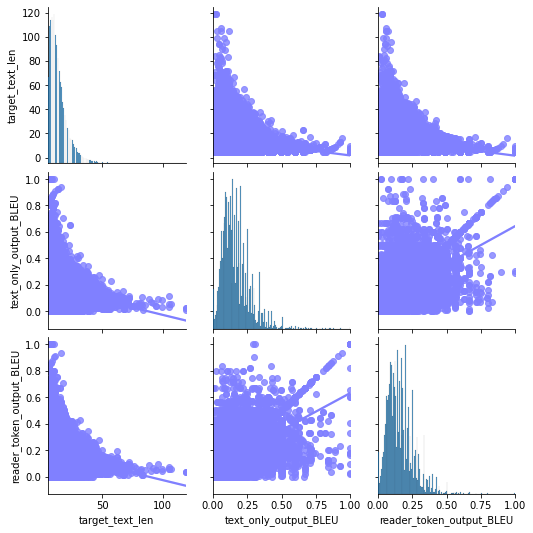

In [8]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(data=combined_data, vars=['target_text_len', 'text_only_output_BLEU', 'reader_token_output_BLEU'], kind='reg', plot_kws={'color' : (0.5, 0.5, 1.0, 0.25)})
plt.show()

Is there any consistent difference in the correlation between question length and model performance?

In [9]:
from scipy.stats import spearmanr, pearsonr
output_vars = ['text_only_output', 'reader_token_output', 'reader_attn_output', 'reader_text_embed_output', 'reader_subreddit_embed_output']
for output_var in output_vars:
    print(f'testing output = {output_var}')
    correl, p_val = spearmanr(combined_data.loc[:, 'target_text_len'].values, 
                              combined_data.loc[:, f'{output_var}_BLEU'].values)
    print(f'correl = {correl}, p={p_val}')

testing output = text_only_output
correl = -0.09048037182457778, p=2.7442067868441005e-102
testing output = reader_token_output
correl = -0.08701576776926362, p=1.012657436913191e-94
testing output = reader_attn_output
correl = -0.17583784836616295, p=0.0
testing output = reader_text_embed_output
correl = -0.08516400118380464, p=8.46199400615569e-91
testing output = reader_subreddit_embed_output
correl = -0.17826901226160516, p=0.0


In general, all models do worse on longer text. The correlation is less severe for the `reader_token` model and `reader_text_embed_output` model than for others.

### Compare questions: type
Do some models do better with different types of questions (e.g. `how` vs. `why`)?

We need a good way to extract the question word from the subject position, so let's try parsing.

In [3]:
## reload data
import torch
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt').data.to_pandas()
print(len(test_data))
## generated data
import gzip
model_output_files = [
    '../../data/reddit_data/text_only_model/test_data_output_text.gz',
    '../../data/reddit_data/author_text_data/test_data_output_text.gz',
    '../../data/reddit_data/author_text_data/author_attention_data/author_attention_layer=5_location=encoder_config=attnconcat/test_data_output_text.gz',
    '../../data/reddit_data/author_text_data/author_subreddit_embed_data/test_data_output_text.gz',
    '../../data/reddit_data/author_text_data/author_text_embed_data/test_data_output_text.gz',
]
model_output_types = [
    'text_only_output',
    'social_token_output',
    'social_attn_output',
    'subreddit_embed_output',
    'text_embed_output',
]
for model_type_i, file_i in zip(model_output_types, model_output_files):
    output_i = list(map(lambda x: x.strip(), gzip.open(file_i, 'rt')))
    test_data = test_data.assign(**{
        model_type_i : output_i
    })

53080


In [6]:
## compute text overlap scores
from test_question_generation import STOP_WORDS, test_question_overlap
# suppress BLEU error message
import warnings
warnings.filterwarnings('ignore')
word_embed_file = '../../data/embeddings/wiki-news-300d-1M.vec.gz'
from nlp.arrow_dataset import Dataset
test_data_torch = Dataset.from_pandas(test_data)
text_overlap_score_data = []
for model_output_type_i in model_output_types:
    print(f'model={model_output_type_i}')
    overlap_score_data_i = test_question_overlap(
        test_data.loc[:, model_output_type_i].values,
        test_data_torch,
        word_embed_file=word_embed_file,
        stop_words=STOP_WORDS,
    )
    # fix column names
    overlap_score_data_i.rename(columns={
        c : f'{model_output_type_i}_{c}'
        for c in overlap_score_data_i.columns
    }, inplace=True)
    text_overlap_score_data.append(overlap_score_data_i)
import pandas as pd
text_overlap_score_data = pd.concat(text_overlap_score_data, axis=1)

In [7]:
text_overlap_score_data.index = test_data.index
combined_test_data = pd.concat([text_overlap_score_data, test_data], axis=1)
print(combined_test_data.shape)

(53080, 42)


In [8]:
## get children of root word C
## check for valid relations: advmod, dobj, attr
## if none, check for determiners on NPs ("which one"): det, advmod
def get_question_modifiers(parser, sentence, question_words, 
                       question_word_deps={'advmod', 'dobj', 'attr', 'aux'}, determiner_deps={'det', 'advmod'},
                       determiner_attach_deps={'acomp', 'dobj', 'attr'}):
    sentence_parse = parser(sentence)
    sentence_root = list(sentence_parse.sents)[0].root
    root_children = list(sentence_root.children)
    # check for question words in immediate children
    modifier_children = list(filter(lambda x: x.dep_ in question_word_deps, root_children))
    question_modifiers = list(filter(lambda x: x.text.lower() in question_words, modifier_children))
    # check for question words in determiners on children
    if(len(question_modifiers) == 0):
        potential_det_parents = list(filter(lambda x: x.dep_ in determiner_attach_deps, root_children))
        det_children = [y for x in potential_det_parents for y in x.children if y.dep_ in determiner_deps]
        question_det_modifiers = list(filter(lambda x: x.text.lower() in question_words, det_children))
        question_modifiers += question_det_modifiers
    # lower-case everything
    question_modifiers = list(map(lambda x: x.text.lower(), question_modifiers))
    return question_modifiers

In [9]:
import spacy
test_sents = ['How many are there?', 'What is the problem?', 'You are going where?', 'And when are you leaving?']
parser = spacy.load('en_core_web_sm')
question_words = {'how', 'when', 'where', 'what', 'who', 'why', 'which', 'do', 'should', 'could', 'would', 'can'}
for sentence in test_sents:
    sentence_parse = parser(sentence)
    sentence_question_modifiers = get_question_modifiers(parser, sentence, question_words)
    print(sentence_question_modifiers)

['how']
['what']
['where']
['when']


In [10]:
from tqdm import tqdm
tqdm.pandas()
combined_test_data = combined_test_data.assign(**{
    'question_word' : combined_test_data.loc[:, 'target_text'].progress_apply(lambda x: get_question_modifiers(parser, x, question_words))
})
combined_test_data = combined_test_data.assign(**{
    'question_word' : combined_test_data.loc[:, 'question_word'].progress_apply(lambda x: x[0] if len(x) > 0 else 'other')
})
# get word counts
question_word_counts = combined_test_data.loc[:, 'question_word'].value_counts()
print(question_word_counts)

100%|██████████| 53080/53080 [00:00<00:00, 722787.27it/s]


other     33131
do         6203
what       4073
how        3214
why        2480
would      1471
can        1004
could       501
where       458
should      271
when        228
which        23
who          23
Name: question_word, dtype: int64


Let's see how the different models do on different questions!!

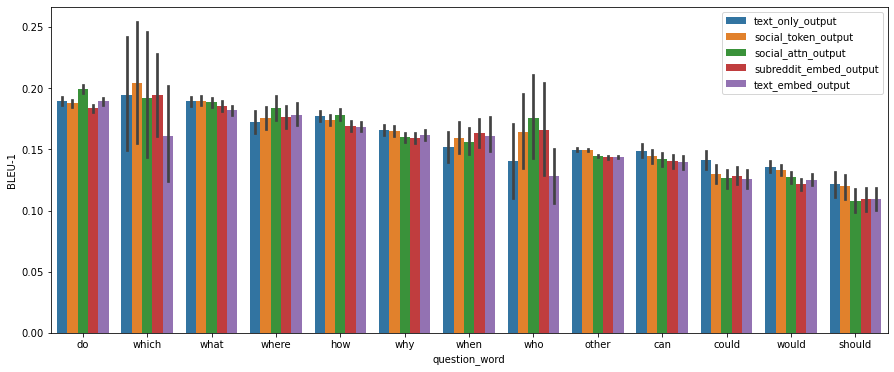

In [11]:
## flatten + plot data
import pandas as pd
overlap_metric = 'BLEU-1'
# overlap_metric = 'ROUGE-L'
data_value_vars = list(filter(lambda x: x.endswith(overlap_metric), combined_test_data.columns))
flat_data = pd.melt(combined_test_data, value_vars=data_value_vars, id_vars=['question_word'], var_name='model_type', value_name=overlap_metric)
flat_data = flat_data.assign(**{'model_type' : flat_data.loc[:, 'model_type'].apply(lambda x: x.replace(f'_{overlap_metric}', ''))})
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 6))
sns.barplot(data=flat_data, x='question_word', y=overlap_metric, hue='model_type', order=sorted(flat_data.loc[:, 'question_word'].unique(), key=lambda x: flat_data[flat_data.loc[:, 'question_word']==x].loc[:, overlap_metric].mean(), reverse=True))
plt.legend(loc='upper right')
plt.show()

- All models do well on `which`, `do`, `what` questions and poorly on `would`, `should`.
- `text_only` model does better on `can`, `could` questions.
- `reader_token` model does slightly better on `when` questions.
- `reader_attn_output` model does better on `which`, `do`, `where`, `who` questions.
- `reader_text_embed` and `reader_subreddit_embed` models do better on `who`, `when` questions.

Let's confirm this result with each type of model on the questions that actually have reader question information.

24342
0.4585908063300678


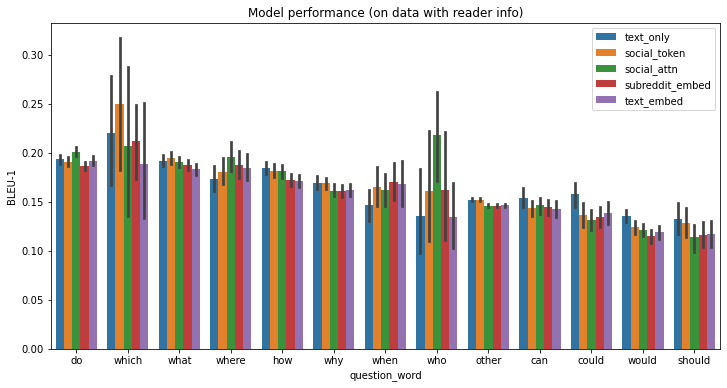

In [12]:
## reader token
combined_test_data_with_reader_token = combined_test_data[(combined_test_data.loc[:, 'reader_token_str']!='UNK') & (combined_test_data.loc[:, 'author_has_subreddit_embed'] | combined_test_data.loc[:, 'author_has_text_embed'])]
print(combined_test_data_with_reader_token.shape[0])
print(combined_test_data_with_reader_token.shape[0]/combined_test_data.shape[0])
## re-flatten data
overlap_metric = 'BLEU-1'
# overlap_metric = 'ROUGE-L'
data_value_vars = list(filter(lambda x: x.endswith(overlap_metric), combined_test_data.columns))
flat_data_with_reader_token = pd.melt(combined_test_data_with_reader_token, value_vars=data_value_vars, id_vars=['question_word'], var_name='model_type', value_name=overlap_metric)
flat_data_with_reader_token = flat_data_with_reader_token.assign(**{'model_type' : flat_data_with_reader_token.loc[:, 'model_type'].apply(lambda x: x.replace(f'_{overlap_metric}', '').replace('_output',''))})
plt.figure(figsize=(12, 6))
sns.barplot(data=flat_data_with_reader_token, x='question_word', y=overlap_metric, hue='model_type', order=sorted(flat_data.loc[:, 'question_word'].unique(), key=lambda x: flat_data[flat_data.loc[:, 'question_word']==x].loc[:, overlap_metric].mean(), reverse=True))
plt.legend(loc='upper right')
plt.title('Model performance (on data with reader info)')
plt.show()

### Test question-post overlap
How much do the questions overlap with the post content?

We can measure this with two metrics:
1. max semantic overlap: find sentence with highest similarity (in sentence embedding) to question
2. topic overlap: compute topic distribution over all posts, compute overall topical alignment with post/question

### Post overlap: semantics

In [13]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
def compute_max_sent_overlap(post_text, question_text, sent_tokenizer, sentence_embed_model):
    post_text_sents = sent_tokenizer.tokenize(post_text)
    post_text_sent_embeds = np.array(list(map(lambda x: sentence_embed_model.encode(x), post_text_sents)))
    question_embed = sentence_embed_model.encode(question_text)
    post_text_sent_question_sims = cosine_similarity(post_text_sent_embeds, question_embed.reshape(1,-1))[:, 0]
    max_sim = post_text_sent_question_sims.max()
    max_sim_sent = post_text_sents[post_text_sent_question_sims.argmax()]
    return (max_sim_sent, max_sim)

In [ ]:
from sentence_transformers import SentenceTransformer
from nltk.tokenize import PunktSentenceTokenizer
from tqdm import tqdm
tqdm.pandas()
sample_size = 5000
np.random.seed(123)
sample_combined_test_data = combined_test_data.sample(sample_size, replace=False) # combined_test_data.loc[np.random.choice(combined_test_data.index, sample_size, replace=False), :]
target_text_vars = ['target_text', 'text_only_output', 'social_token_output', 'social_attn_output', 'text_embed_output', 'subreddit_embed_output']
# target_text_vars = ['target_text']
sentence_embed_model = SentenceTransformer('paraphrase-distilroberta-base-v1')
sent_tokenizer = PunktSentenceTokenizer()
for target_text_var in target_text_vars:
    print(f'testing text={target_text_var}')
    sample_combined_test_data = sample_combined_test_data.assign(**{
        f'{target_text_var}_max_sim_sent' : sample_combined_test_data.progress_apply(lambda x: compute_max_sent_overlap(x.loc['source_text'],  x.loc[target_text_var], sent_tokenizer, sentence_embed_model), axis=1)
    })

testing text=target_text


  7%|▋         | 337/5000 [00:28<09:48,  7.93it/s]

In [ ]:
## separate sents and sim values
for target_text_var in target_text_vars:
    sample_combined_test_data = sample_combined_test_data.assign(**{
        f'{target_text_var}_max_sim_sent_val' : sample_combined_test_data.loc[:, f'{target_text_var}_max_sim_sent'].apply(lambda x: x[1]),
        f'{target_text_var}_max_sim_sent' : sample_combined_test_data.loc[:, f'{target_text_var}_max_sim_sent'].apply(lambda x: x[0]),
    })

What are some sentences with high post similarity?

In [25]:
max_sim_cutoff_val = 1-1e-3 # removing duplicates
target_text_vars = ['target_text', 'text_only_output', 'social_token_output', 'social_attn_output', 'text_embed_output', 'subreddit_embed_output']
for target_text_var_i in target_text_vars:
    # restrict to relevant data
    if(target_text_var in {'reader_token_output', 'reader_attn_output'}):
        sample_combined_test_data_i = sample_combined_test_data[sample_combined_test_data.loc[:, 'reader_token']!='UNK']
    elif(target_text_var in {'reader_text_embed_output', 'reader_subreddit_embed_output'}):
        sample_combined_test_data_i = sample_combined_test_data[sample_combined_test_data.loc[:, 'author_has_subreddit_embed'] & sample_combined_test_data.loc[:, 'author_has_text_embed']]
    else:
        sample_combined_test_data_i = sample_combined_test_data.copy()
    display(sample_combined_test_data_i[sample_combined_test_data_i.loc[:, f'{target_text_var_i}_max_sim_sent_val']<=max_sim_cutoff_val].sort_values(f'{target_text_var_i}_max_sim_sent_val', inplace=False, ascending=False).loc[:, ['source_text', 'target_text', f'{target_text_var_i}_max_sim_sent', f'{target_text_var_i}_max_sim_sent_val', target_text_var_i]].head(10))
    display(sample_combined_test_data_i[sample_combined_test_data_i.loc[:, f'{target_text_var_i}_max_sim_sent_val']<=max_sim_cutoff_val].sort_values(f'{target_text_var_i}_max_sim_sent_val', inplace=False, ascending=True).loc[:, ['source_text', 'target_text', f'{target_text_var_i}_max_sim_sent', f'{target_text_var_i}_max_sim_sent_val', target_text_var_i]].head(10))

,source_text,target_text,target_text_max_sim_sent,target_text_max_sim_sent_val,target_text
14208,Hello world. I'm a big fan of Ramit Sethi's *...,"Is it due to the tax structure, or the flexibi...","Is it due to the tax structure, or the flexib...",0.971504,"Is it due to the tax structure, or the flexibi..."
5270,TLDR: I am repaying a scholarship for not meet...,And they cannot provide a statement?,They cannot provide a statement.,0.906710,And they cannot provide a statement?
20397,"I recently started dating this guy, and with h...","So, is it normal?",Is that normal?,0.872562,"So, is it normal?"
34456,okay so i’m in high school and me and this guy...,What would you do?,what do i do?,0.819994,What would you do?
42422,"I went to Walmart to get groceries. Yes, this...",I absolutely agree that you are sorry?,"and I responded with ""I absolutely agree that ...",0.806616,I absolutely agree that you are sorry?
9083,I recently built my first gaming PC and I am c...,Or would it be better with 240hz 1080p monitor?,Or would it be better to go with a 144 hz 1080...,0.805031,Or would it be better with 240hz 1080p monitor?
20159,"While I grew up in houses, I've been living in...","""PS obviously all the financials have been iro...",What tips helped you out?PS obviously all the ...,0.785653,"""PS obviously all the financials have been iro..."
48486,So I've been buying pants that make me uncomfo...,Can you buy pants in a larger size and have th...,Where can I get pants in my freakish size?,0.764906,Can you buy pants in a larger size and have th...
38601,"I was arrested, fingerprinted and mugshot for ...",Are you asking is it a crime to arrest you for...,Is it legal to be arrested for a violation?,0.748042,Are you asking is it a crime to arrest you for...
39030,**I have ADHD and can't comprehend anything I...,Why are you not allowed to be medicated?,I am not allowed to be medicated.,0.747198,Why are you not allowed to be medicated?


,source_text,target_text,target_text_max_sim_sent,target_text_max_sim_sent_val,target_text
23721,Lesbian: &amp;#x200B;A word used for a straigh...,What do you need help with?,Lesbian: &amp;#x200B;A word used for a straigh...,-0.056522,What do you need help with?
5417,"I was an introvert for most of my childhood, t...",Does that make any sense?,"I was an introvert for most of my childhood, t...",-0.039247,Does that make any sense?
5884,This might sound dumb but I'm starting to thin...,Do you know your price?,I believe I'm craving love from others because...,-0.032006,Do you know your price?
4330,So I did a Google search and I found a website...,How are we supposed to know?,So I did a Google search and I found a website...,-0.028767,How are we supposed to know?
28863,So the problem is when I press the power butto...,What is your mobo?,PS: sry for my bad English.,-0.026783,What is your mobo?
10205,I got a rare medical condition through which m...,Do you mean a loan?,I got a rare medical condition through which m...,-0.025441,Do you mean a loan?
16574,Ik this is kinda offtopic but I need someone’s...,Where are you getting the drivers from?,Ik this is kinda offtopic but I need someone’s...,-0.014119,Where are you getting the drivers from?
30408,"https://i.redd.it/q2q2d7xjqys11.jpgHello, I fi...",How is the cable management?,"https://i.redd.it/q2q2d7xjqys11.jpgHello, I fi...",-0.003042,How is the cable management?
46346,[PCPartPicker Part List](https://be.pcpartpick...,Why get 2 monitors when you can get one super ...,[PCPartPicker Part List](https://be.pcpartpick...,-0.001690,Why get 2 monitors when you can get one super ...
5814,What’s the best way to move a PC will be drivi...,Is the computer watercooled?,What’s the best way to move a PC will be drivi...,-0.000485,Is the computer watercooled?


,source_text,target_text,text_only_output_max_sim_sent,text_only_output_max_sim_sent_val,text_only_output
4987,A couple weeks ago my husband's side of the fa...,"That’s your right, but again what are you acco...",What wrong with being gay?,0.973576,What's wrong with being gay?
20988,"I've posted this once before, and spent countl...",Also are you using tdie or tctl for the degree...,Is my coolermaster aio trash?,0.972442,Is the coolermaster aio trash?
8311,I'm on mobile. So what? English is not my firs...,Have you ever looked into family therapy?,Is this really my fault?,0.923838,Is it really your fault?
45781,So some friends of mine keep talking about tak...,"That is, what else could be done with the time...",What are some flaws and things to consider tha...,0.886590,What are your flaws that you need to let them ...
10640,"Many years back, when we were building our cre...",Do plan on making big purchases that will requ...,Is there a reason to hang onto it?,0.879483,Why do you want to hang onto it?
7688,"Hello, fellow redditors. I'm 16, and I started...","ATM fees, what are those?",Am I missing anything else?What's the differen...,0.877716,What's the difference between a debit card and...
5508,There are many things that I want to change ab...,Do you act a certain way when you drink too much?,So how do I do this?,0.860353,How do you do it?
11763,Recently married couple with a baby on the way...,"Where's your emergency fund, and what if the A...",Is this a good or a bad idea?,0.847526,Is it a good idea?
36017,PF - sorry for the messy title. I come to you ...,Do you have any online access to your FSA acco...,?Or am I basically screwed and need to eat a t...,0.847038,Why do you have to eat a tub full of ice cream?
6750,I’m a woman in my early 30s. I have been out o...,"Guys also get shafted by this, they're expecte...",What should I do on first dates?,0.838779,How about a first date?


,source_text,target_text,text_only_output_max_sim_sent,text_only_output_max_sim_sent_val,text_only_output
27724,My pc works fine rn but I wanna upgrade it to ...,well what do you value more?,My pc works fine rn but I wanna upgrade it to ...,-0.080299,What is your budget?
40336,Throw away account for obvious reasons.If I ca...,Are you trying to sell someone out for a ticket?,Throw away account for obvious reasons.If I ca...,-0.041001,What state are you in?
10205,I got a rare medical condition through which m...,Do you mean a loan?,I got a rare medical condition through which m...,0.004102,How long ago was this?
3739,[PCPartPicker Part List](https://pcpartpicker....,I've seen you posting here before numerous tim...,[PCPartPicker Part List](https://pcpartpicker....,0.008506,What is your total budget?
23868,"Just a heads up that when I mention posting, I...",Do you talk to them individually on those spec...,Then when I posted on Father’s Day but not Mot...,0.019666,What did you expect?
47887,The place was very dirty and my wife and I had...,Did you take pictures and report it to your LL?,The place was very dirty and my wife and I had...,0.020191,What do you want to happen?
5417,"I was an introvert for most of my childhood, t...",Does that make any sense?,"I was an introvert for most of my childhood, t...",0.022093,"So, how do you deal with that?"
39744,My computer gets very loud when I’m playing de...,What are your component temps?,My computer gets very loud when I’m playing de...,0.031905,Is it a single core or dual core?
28277,I broke my phone after Christmas and i still h...,So I'm guessing the argument would be made tow...,I broke my phone after Christmas and i still h...,0.034143,How old are you?
19554,He goes to school full-time and I cover his ex...,Did he cost you an EXTRA 500?,Recently he bought his girlfriend a $500 ring.,0.038708,Do you live together?


,source_text,target_text,social_token_output_max_sim_sent,social_token_output_max_sim_sent_val,social_token_output
954,I tolerate them. Individual people are fine so...,"You know, I found people annoyed me and I was ...",“What can I learn from this person?,0.911739,"Also, what do you have to learn from this person?"
20963,"I'll be getting over $2,000 back on my tax ret...",Where are you going to get money for repairs?,What are you doing with your tax return?,0.902380,How much do you owe on your tax return?
684,He goes to school full-time and I cover his ex...,INFO: did you even try talking to him about it?,Recently he bought his girlfriend a $500 ring.,0.901135,He bought his girlfriend a $500 ring??
16119,I’m 21 this year and I was in the process of r...,Do you have hobbies?,What do I do?,0.896681,What do you do?
10640,"Many years back, when we were building our cre...",Do plan on making big purchases that will requ...,Is there a reason to hang onto it?,0.879483,Why do you want to hang onto it?
11763,Recently married couple with a baby on the way...,"Where's your emergency fund, and what if the A...",Is this a good or a bad idea?,0.847526,Is it a good idea?
36017,PF - sorry for the messy title. I come to you ...,Do you have any online access to your FSA acco...,?Or am I basically screwed and need to eat a t...,0.847038,Why do you have to eat a tub full of ice cream?
40022,I just applied for a capital one quicksilver c...,Or is it within a certain timeframe?,Is it okay to use it as a debit card for purch...,0.832219,"With the cash back rewards, what incentive doe..."
29360,"First off, this is a throwaway account because...",How is she going to see herself after that?,The issue is she *really really* wants to beco...,0.813130,Do you really want her to become an astronaut ...
32746,"Long story short, we signed our rental agreeme...",What does your current lease say about pets?,They re-did the rental agreement and sent it t...,0.803462,They re-did the rental agreement with you?


,source_text,target_text,social_token_output_max_sim_sent,social_token_output_max_sim_sent_val,social_token_output
40336,Throw away account for obvious reasons.If I ca...,Are you trying to sell someone out for a ticket?,Throw away account for obvious reasons.If I ca...,-0.041001,What state are you in?
48571,"I tried to make a Tinder account, but I accide...",Or use a different email/phone account in acco...,"I tried to make a Tinder account, but I accide...",-0.039669,What are you looking to do?
33614,"\[UserBenchmarks: Game 12%, Desk 24%, Work 15%...","EDIT : apart from the result on Userbenchmark,...","\[UserBenchmarks: Game 12%, Desk 24%, Work 15%...",-0.034988,Do you have the option to get out of the lease...
10205,I got a rare medical condition through which m...,Do you mean a loan?,I got a rare medical condition through which m...,0.004102,How long ago was this?
42453,I started an LLC with someone that I met at co...,Where is the LLC incorporated?,It was going to be an app.&amp;#x200B;We won a...,0.008149,What state are you in?
3739,[PCPartPicker Part List](https://pcpartpicker....,I've seen you posting here before numerous tim...,[PCPartPicker Part List](https://pcpartpicker....,0.008506,What is your total budget?
49319,I read a post about someone in a similar situa...,But I have to ask how parents at this school a...,It’s hard to tell his exact age because he is ...,0.010141,Are you in the UK?
46045,"So just a little backstory, I was in a abusive...",Do you provide for your child or do you pin th...,I'm now with a man who has been my best friend...,0.011216,Where are you located?
33435,so my pc is upstairs and my router is downstai...,How big is your place?,so my pc is upstairs and my router is downstai...,0.018013,How long has it been running?
23868,"Just a heads up that when I mention posting, I...",Do you talk to them individually on those spec...,Then when I posted on Father’s Day but not Mot...,0.019666,What did you expect?


,source_text,target_text,social_attn_output_max_sim_sent,social_attn_output_max_sim_sent_val,social_attn_output
50519,"Hey, I'm hoping that someone can point me in t...",What's the out of pocket max on your health in...,I have health insurance through my employer.,0.739390,Do you have health insurance?
12450,What should I do with my leftover from my budg...,What rates are your loans at?,What should I do with my leftover from my budget?,0.716985,Do you have a budget?
12282,Hello! We are a young married couple (I’m 21 a...,What are you currently saving for retirement e...,Our question: should we buy a car with cash or...,0.712734,Are you planning to buy a car in the next 5 ye...
24864,When I read silently everything is smooth and ...,"When you read, do you 'hear' your voice in you...",Is it something I should talk to a doctor abou...,0.693518,Do you have a local doctor you can talk to abo...
17811,To make a long story short I left my abusive h...,Are minimum payments on all of the cards feasi...,Anyways how would you focus on getting your cr...,0.693075,Do you have a credit card already?
44519,I am trying to take the first steps in improvi...,Are you 100% certain that that apartment isn't...,I still owe on the car.,0.690174,What is the car worth and how much do you owe?
36442,Hi guys! I’ve always gotten great advice from ...,How often do you fly with JetBlue/year?,I’m wondering if opening another credit card a...,0.677504,Do you have a credit card?
3067,My girlfriend and I bought a house together at...,"Tenants in common, joint owners, etc?",She has more equity in the house than I do.,0.675301,Is there any equity in the house?
22255,My fiancé is in nursing school. He’s currently...,"Like, did he himself sign up for this facility?",What should he do?,0.673840,What did he want you to do?
26809,"18 years old, ~$3,300 in my account from worki...",Is it reasonable to make another $3k relativel...,"Unfortunately, the car’s transmission and comp...",0.660809,How much would it cost you to replace the car ...


,source_text,target_text,social_attn_output_max_sim_sent,social_attn_output_max_sim_sent_val,social_attn_output
23721,Lesbian: &amp;#x200B;A word used for a straigh...,What do you need help with?,Lesbian: &amp;#x200B;A word used for a straigh...,-0.095338,How old are you?
27724,My pc works fine rn but I wanna upgrade it to ...,well what do you value more?,My pc works fine rn but I wanna upgrade it to ...,-0.081286,What are you trying to achieve?
46179,So pretty much I’m an awkward 17 yo who has be...,"Well, what do you mean by ""snagging""?",So pretty much I’m an awkward 17 yo who has be...,-0.076637,What do you have to lose?
52800,Time magazine said recently that a study done ...,Does that make a person feel cheerful and frie...,Time magazine said recently that a study done ...,-0.066652,"What do you mean by ""don't have anything to do..."
10205,I got a rare medical condition through which m...,Do you mean a loan?,I got a rare medical condition through which m...,-0.043721,How old are you?
48571,"I tried to make a Tinder account, but I accide...",Or use a different email/phone account in acco...,"I tried to make a Tinder account, but I accide...",-0.040313,What do you mean?
38620,sᴏ ʙᴀsɪᴄᴀʟʟʏ ᴍʏ ᴘᴀʀᴇɴᴛs ᴀʀᴇ ᴛʜᴇ ᴜsᴜᴀʟ ғᴀᴄᴇʙᴏᴏᴋ...,What the hell did you do the font?,sᴏ ᴛʜᴇ ᴅʏɪɴɢ ᴀɴᴛɪᴠᴀx ᴋɪᴅs ᴍᴇᴍᴇs ᴋɪɴᴅᴀ ɢᴏᴛ ᴛᴏ ᴍ...,-0.035398,What is the current payoff?
38261,Ive read there is a 5 year gap for 14-15 year ...,What if you were in HS together and at the lib...,Ive read there is a 5 year gap for 14-15 year ...,-0.031885,What kind of music do you play?
11840,"Hey , My pc is so old I currently have the i5-...",How is your average ping time on servers?,"Hey , My pc is so old I currently have the i5-...",-0.031344,What are you going to be using it for?
48126,As title says E.G I’m doing 40 on a 35 speed l...,Do you have anger issues?,As title says E.G I’m doing 40 on a 35 speed l...,-0.026649,Did you get it inspected *before* purchase?


,source_text,target_text,text_embed_output_max_sim_sent,text_embed_output_max_sim_sent_val,text_embed_output
15682,My kitty just passed away on 3/22/19. I am loo...,Did you attempted to have a follow up appointm...,Can I get some compensation for the vet bills?,0.741422,How much did those vet bills cost?
28893,I am a 26-year-old male. I've worked in the se...,Is your job secure?,And how much money do I put into it?,0.707764,What is this money going to be invested in?
3971,"Hey reddit, hope your July 4th is going better...",Or are you unwilling to touch your savings in ...,I spoke to a realtor last week.,0.704366,Have you spoken to a realtor?
3176,I'm up for lease renewal next month and I'm be...,How much do you like this apartment?,Is this a relatively common rent increase?,0.704035,How much is your rent?
52399,"I’m trying to rent a 3 bed, 3 bath unit inside...",Out of curiosity what is their definition of r...,Can the HOA tell me I can not rent to them?,0.693229,What does your lease say about the HOA rules?
51874,Good evening to everyone! Hopefully someone ca...,Have you spoken with the landlord?,It is my understanding that a lease is binding...,0.692215,What kind of lease do you have?
37706,I have a student loan debt balance of roughly ...,And then I think after 30 years or something i...,Should I contribute every last penny to my stu...,0.688552,What’s the interest rate on the student loans?
52439,I have a student loan debt balance of roughly ...,Did you complete law school?,Should I contribute every last penny to my stu...,0.688552,What’s the interest rate on the student loans?
3301,I have a student loan debt balance of roughly ...,Can you just leave your dog alone during the day?,Should I contribute every last penny to my stu...,0.688552,What’s the interest rate on the student loans?
17811,To make a long story short I left my abusive h...,Are minimum payments on all of the cards feasi...,Anyways how would you focus on getting your cr...,0.683657,What is your credit score?


,source_text,target_text,text_embed_output_max_sim_sent,text_embed_output_max_sim_sent_val,text_embed_output
15235,https://www.techspot.com/article/1554-meltdown...,what the hell is wrong with those assassins cr...,https://www.techspot.com/article/1554-meltdown...,-0.149290,Why would you want to do that?
33614,"\[UserBenchmarks: Game 12%, Desk 24%, Work 15%...","EDIT : apart from the result on Userbenchmark,...","\[UserBenchmarks: Game 12%, Desk 24%, Work 15%...",-0.115811,Do you have an air conditioner in your case?
7049,My girlfriend broke it between me and her toda...,How old are you?,My girlfriend broke it between me and her toda...,-0.065540,Do you have a job?
16198,Details:The dead friend is German I am from Mo...,Under what conditions did your friend pass?,Details:The dead friend is German I am from Mo...,-0.048733,What state are you in?
32131,Here is the situation:\- 'employee x' works as...,Why would you want to do all that and not get ...,Here is the situation:\- 'employee x' works as...,-0.047181,Are you sure you aren’t trying to make this a ...
10205,I got a rare medical condition through which m...,Do you mean a loan?,I got a rare medical condition through which m...,-0.043721,How old are you?
26520,The problem is my phone isn't getting detected...,Is the phone set to transfer files via USB in ...,The problem is my phone isn't getting detected...,-0.029609,What do you want to do with it?
38620,sᴏ ʙᴀsɪᴄᴀʟʟʏ ᴍʏ ᴘᴀʀᴇɴᴛs ᴀʀᴇ ᴛʜᴇ ᴜsᴜᴀʟ ғᴀᴄᴇʙᴏᴏᴋ...,What the hell did you do the font?,sᴏ ʙᴀsɪᴄᴀʟʟʏ ᴍʏ ᴘᴀʀᴇɴᴛs ᴀʀᴇ ᴛʜᴇ ᴜsᴜᴀʟ ғᴀᴄᴇʙᴏᴏᴋ...,-0.027389,Is there any way you can change your mind?
16333,&amp;#x200B;https://preview.redd.it/h7iakuyoqp...,Do you want to enable or disable it?,&amp;#x200B;https://preview.redd.it/h7iakuyoqp...,-0.023703,How do we know for sure every 2nd gen ryzen is...
9822,What are the best ways for married people to h...,What does your partner want?,Should some things be kept separate and some c...,-0.021533,What are you talking about?


,source_text,target_text,subreddit_embed_output_max_sim_sent,subreddit_embed_output_max_sim_sent_val,subreddit_embed_output
50519,"Hey, I'm hoping that someone can point me in t...",What's the out of pocket max on your health in...,I have health insurance through my employer.,0.779422,Would you be eligible to get health insurance ...
10069,I'm a 21 year old young lady and I have 20k sa...,Living at home with parents?,A Roth IRA is best I think?,0.757857,Do you mean a Roth IRA?
25204,I’m located in Ohio. Backstory: I’ve suffered ...,Have you worked there at least a year?,Am I missing any steps to get FMLA?,0.756134,Do you qualify for FMLA?
13471,So me (F27) and my boyfriend (M26) were togeth...,"Did you both look into IVF, where you select e...",I still love him.,0.750565,Do you still love him?
34741,"Long time lurker. I'm 28, college grad, making...","Also, do you have plans for kids in the future...",Do we buy a house or do I aggressively focus o...,0.745593,Have you considered refinancing your student l...
35698,A month ago I received a letter served at work...,"Wait, are you consulting lawyers together or s...",I obviously will cover the child with my healt...,0.730033,Does your mother provide all the costs of the ...
17919,"I am a 33 year old male, living in Kentucky, m...",Have you priced that out?,Is there a good formula to figure out what a g...,0.711701,Do you have a 3-6 month emergency fund?
44842,I was talking to a friend's parents and they f...,$295/mo for 2 people near 400% FPL sounds low;...,Also how is the 401k viewed?,0.710222,"So the question is, what is their max income o..."
24604,"I used to be a vet tech, but I left my career ...",As long as you're taking care of them why do t...,Do I really have that many pets?,0.703456,Do you not have pets?
17811,To make a long story short I left my abusive h...,Are minimum payments on all of the cards feasi...,Anyways how would you focus on getting your cr...,0.700591,Did you close the credit cards?


,source_text,target_text,subreddit_embed_output_max_sim_sent,subreddit_embed_output_max_sim_sent_val,subreddit_embed_output
7049,My girlfriend broke it between me and her toda...,How old are you?,My girlfriend broke it between me and her toda...,-0.098681,What country are you in?
34875,So i just upgradet to a Rx 5700 XT red devil a...,Do you get any message from your screen such a...,So i just upgradet to a Rx 5700 XT red devil a...,-0.081728,What's your budget?
52800,Time magazine said recently that a study done ...,Does that make a person feel cheerful and frie...,Time magazine said recently that a study done ...,-0.056812,Isn’t there a point of view?
27284,I get an error that looks like this quite ofte...,What are your System specs ?,I get an error that looks like this quite ofte...,-0.048141,How do you dress up?
25481,I know my PC's specs are pretty bad but it is ...,Are you plugged into your video card ( rather ...,I know my PC's specs are pretty bad but it is ...,-0.041792,"Also, what is your budget?"
28740,except for Corsair Obsidian Series 1000D which...,Do you want dual ATX or ATX + mATX?,except for Corsair Obsidian Series 1000D which...,-0.039786,What are you running for?
15676,"So I'm a junior in high school, average a 3.8 ...",Would you entertain the idea of medicine or th...,Eventually I lost interest in pursuing botany ...,-0.035081,How is this a question?
37987,I'm torn between building or buying a CyberPow...,Why do you want to install Windows 7?,I'm torn between building or buying a CyberPow...,-0.034992,What's your budget?
48118,Throw away for obvious reasons When I was 19 I...,"INFO: When you say ""we aren't related"" do you ...",Throw away for obvious reasons When I was 19 I...,-0.017739,Did she ask you to move?
2477,I am trying to look for pictures of fashion fr...,How far back are we talking?,I am trying to look for pictures of fashion fr...,-0.012215,Is it really that easy?


These questions generally make sense in terms of matching with post text.

Let's look at the overall distributions.

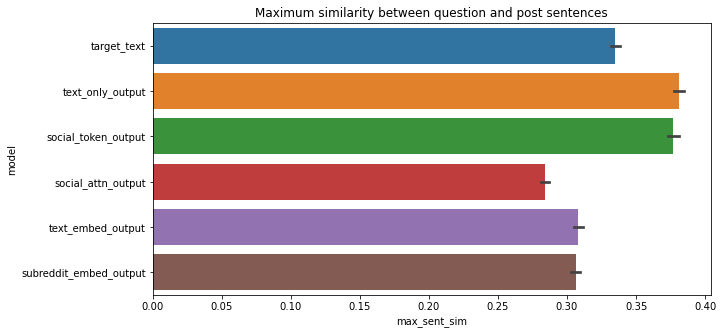

In [26]:
## flatten data lol
target_text_vars = ['target_text', 'text_only_output', 'social_token_output', 'social_attn_output', 'text_embed_output', 'subreddit_embed_output']
sent_sim_vars = [f'{x}_max_sim_sent_val' for x in target_text_vars]
flat_sent_sim_data = pd.melt(sample_combined_test_data.loc[:, sent_sim_vars], value_vars=sent_sim_vars, var_name='model', value_name='max_sent_sim')
flat_sent_sim_data = flat_sent_sim_data[flat_sent_sim_data.loc[:, 'max_sent_sim']<=max_sim_cutoff_val]
# clean model name
flat_sent_sim_data = flat_sent_sim_data.assign(**{
    'model' : flat_sent_sim_data.loc[:, 'model'].apply(lambda x: x.replace('_max_sim_sent_val', ''))
})
## plot everything
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(data=flat_sent_sim_data, y='model', x='max_sent_sim')
plt.title('Maximum similarity between question and post sentences')
plt.show()

OK! The simplest models tend to produce answers with high similarity. That's not necessarily a bad thing for the other models! The reader attention model and the reader embedding models might be generating questions that seek *new information*.

Let's verify this on the data with reader tokens and the data with reader embeds.

In [64]:
def plot_sent_sim(data, target_text_vars):
    sent_sim_vars = [f'{x}_max_sim_sent_val' for x in target_text_vars]
    flat_sent_sim_data = pd.melt(data.loc[:, sent_sim_vars], value_vars=sent_sim_vars, var_name='model', value_name='max_sent_sim')
    flat_sent_sim_data = flat_sent_sim_data[flat_sent_sim_data.loc[:, 'max_sent_sim']<=max_sim_cutoff_val]
    # clean model name
    flat_sent_sim_data = flat_sent_sim_data.assign(**{
        'model' : flat_sent_sim_data.loc[:, 'model'].apply(lambda x: x.replace('_max_sim_sent_val', '').replace('_output', ''))
    })
    ## plot everything
    plt.figure(figsize=(10,5))
    sns.barplot(data=flat_sent_sim_data, y='model', x='max_sent_sim')
    plt.title('Maximum similarity between question and post sentences')
    plt.show()

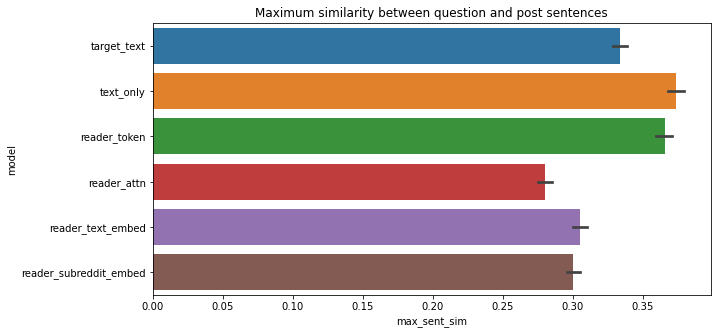

In [65]:
## reader tokens
sample_combined_test_data_with_reader_tokens = sample_combined_test_data[(sample_combined_test_data.loc[:, 'reader_token_str']!='UNK') &  (sample_combined_test_data.loc[:, 'author_has_subreddit_embed'] & sample_combined_test_data.loc[:, 'author_has_text_embed'])]
target_text_vars = ['target_text', 'text_only_output', 'reader_token_output', 'reader_attn_output', 'reader_text_embed_output', 'reader_subreddit_embed_output']
plot_sent_sim(sample_combined_test_data_with_reader_tokens, target_text_vars)

The model differences on the sub-set data are basically the same as the full data.

### Post overlap: topic

In [249]:
# optional: extract best vocab from all posts
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import WordPunctTokenizer
from stop_words import get_stop_words
en_stops = get_stop_words('en')
word_tokenizer = WordPunctTokenizer()
cv = CountVectorizer(min_df=0.0001, max_df=0.25, stop_words=en_stops, tokenizer=word_tokenizer.tokenize)
dtm = cv.fit_transform(combined_data.loc[:, 'source_text'].values)
# show top words
print(f'top words in docs')
print(pd.Series(np.array(dtm.sum(axis=0))[0], index=sorted(cv.vocabulary_, key=cv.vocabulary_.get)).sort_values(inplace=False, ascending=False).head(10))
dtm_vocab = set(cv.vocabulary_.keys())
# get corpus for LDA
from gensim.corpora import Dictionary
from nltk.tokenize import WordPunctTokenizer
word_tokenizer = WordPunctTokenizer()
source_text_tokens = combined_data.loc[:, 'source_text'].apply(lambda x: list(filter(lambda y: y in dtm_vocab, word_tokenizer.tokenize(x))))
lda_dict = Dictionary(source_text_tokens)
lda_corpus = source_text_tokens.apply(lda_dict.doc2bow).values
## find best # topics based on coherence
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
k_topics = [5, 10, 15, 20]
topic_metrics = []
for k_topic in k_topics:
    print(f'testing topics = {k_topic}')
    lda_model = LdaModel(lda_corpus, num_topics=k_topic, alpha='symmetric', iterations=100)
    print(f'computing coherence')
    coherence_model = CoherenceModel(model=lda_model, corpus=lda_corpus, texts=source_text_tokens, dictionary=lda_dict, coherence='c_v')
    coherence_k = coherence_model.get_coherence()
    topic_metrics.append(coherence_k)
topic_metrics = pd.Series(topic_metrics, index=k_topics)
print(topic_metrics)

top words in docs
$        43571
"        42040
:        26893
didn     23718
money    22976
;        22778
feel     22336
since    21575
think    20997
home     20821
dtype: int64
testing topics = 5
computing coherence
testing topics = 10
computing coherence
testing topics = 15
computing coherence
testing topics = 20
computing coherence
5     0.388676
10    0.420840
15    0.404000
20    0.387441
dtype: float64


In [250]:
optimal_k_topic = 10
lda_model = LdaModel(lda_corpus, num_topics=optimal_k_topic, alpha='symmetric', id2word=lda_dict, iterations=100)
# show top words per topic
lda_model.print_topics(num_words=10)

[(0,
  '0.038*"$" + 0.013*"money" + 0.012*"pay" + 0.010*"job" + 0.010*"month" + 0.008*"credit" + 0.008*"%" + 0.008*":" + 0.007*"debt" + 0.007*"000"'),
 (1,
  '0.021*""" + 0.009*"friends" + 0.008*"feel" + 0.008*"friend" + 0.008*"people" + 0.006*"didn" + 0.006*"think" + 0.006*"say" + 0.005*"something" + 0.005*"guy"'),
 (2,
  '0.013*"school" + 0.012*"parents" + 0.010*"son" + 0.010*"mother" + 0.009*"kids" + 0.008*"daughter" + 0.008*"family" + 0.007*""" + 0.006*"mom" + 0.006*"us"'),
 (3,
  '0.052*";" + 0.047*"amp" + 0.036*";#" + 0.026*"&" + 0.025*":" + 0.016*".&" + 0.012*"://" + 0.012*"com" + 0.011*"https" + 0.009*"**"'),
 (4,
  '0.016*"dog" + 0.009*""" + 0.009*"people" + 0.008*"water" + 0.008*"food" + 0.008*"day" + 0.006*"boss" + 0.006*")." + 0.005*"asked" + 0.005*"hours"'),
 (5,
  '0.014*"account" + 0.010*"dad" + 0.009*"sister" + 0.008*"mom" + 0.008*"help" + 0.007*"phone" + 0.007*"card" + 0.006*"tried" + 0.006*"check" + 0.006*"dont"'),
 (6,
  '0.010*"feel" + 0.009*"husband" + 0.008*"thing

These seem mainly split between `money` and `family` words, which makes sense.

In [264]:
# get topics for all documents
post_topics = lda_model.get_document_topics(lda_corpus, minimum_probability=0.)
post_topics = pd.DataFrame(list(map(lambda x: pd.Series(dict(x)), post_topics)))

(59273, 10)


,0,1,2,3,4,5,6,7,8,9
0,0.002861,0.002861,0.096314,0.571527,0.002861,0.071558,0.002861,0.243434,0.002861,0.002861
1,0.043867,0.000585,0.000585,0.000585,0.951453,0.000585,0.000585,0.000585,0.000585,0.000585
2,0.000505,0.000505,0.000505,0.000505,0.000505,0.923927,0.000505,0.000505,0.000505,0.072030
3,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.995158
4,0.000820,0.000820,0.000820,0.000820,0.000820,0.000820,0.992622,0.000820,0.000820,0.000820


In [280]:
## compute cosine similarity between post and question topics, for each post-question pair
from sklearn.metrics.pairwise import cosine_similarity
target_text_vars = ['target_text', 'text_only_output', 'reader_token_output', 'reader_attn_output', 'reader_text_embed_output', 'reader_subreddit_embed_output']
combined_data_topic_sims = []
for target_text_var in target_text_vars:
    print(f'testing topics for var={target_text_var}')
    question_lda_tokens = combined_data.loc[:, target_text_var].apply(lambda x: list(filter(lambda y: y in dtm_vocab, word_tokenizer.tokenize(x))))
    question_lda_corpus = question_lda_tokens.apply(lda_dict.doc2bow).values
    question_topics = lda_model.get_document_topics(question_lda_corpus, minimum_probability=0.)
    question_topics = pd.DataFrame(list(map(lambda x: pd.Series(dict(x)), question_topics)))
    post_question_sims = []
    for i in tqdm(range(post_topics.shape[0])):
        post_question_sim_i = cosine_similarity(post_topics.iloc[i, :].values.reshape(1,-1), question_topics.iloc[i, :].values.reshape(1,-1))[0][0]
        post_question_sims.append(post_question_sim_i)
    post_question_sims = pd.DataFrame(post_question_sims, columns=['post_question_topic_sim']).assign(**{'model' : target_text_var})
    combined_data_topic_sims.append(post_question_sims)
combined_data_topic_sims = pd.concat(combined_data_topic_sims, axis=0)

testing topics for var=target_text


100%|██████████| 59273/59273 [00:23<00:00, 2498.68it/s]


testing topics for var=text_only_output


100%|██████████| 59273/59273 [00:23<00:00, 2488.53it/s]


testing topics for var=reader_token_output


100%|██████████| 59273/59273 [00:25<00:00, 2338.64it/s]


testing topics for var=reader_attn_output


100%|██████████| 59273/59273 [00:27<00:00, 2178.75it/s]


testing topics for var=reader_text_embed_output


100%|██████████| 59273/59273 [00:26<00:00, 2242.06it/s]


testing topics for var=reader_subreddit_embed_output


100%|██████████| 59273/59273 [00:26<00:00, 2276.07it/s]


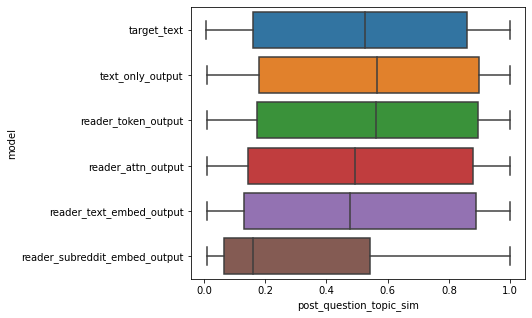

In [288]:
## plot post-topic sims
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,5))
sns.boxplot(data=combined_data_topic_sims, x='post_question_topic_sim', y='model')
plt.show()

OK! 

- The `text_only` model and `reader_token` model seem to "overfit" and produce text that is more topically similar than the actual questions.
- The `reader_attn` model and `text_embed` model are a bit closer to the expected value of topical similarity.